In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [6]:
# Load the dataset
data = pd.read_csv('./datasets/salaries.csv')

In [7]:
# Data exploration
print(data.head())
print(data.info())
print(data.describe())

   work_year experience_level employment_type                  job_title  \
0       2024               SE              FT                AI Engineer   
1       2024               SE              FT                AI Engineer   
2       2024               SE              FT              Data Engineer   
3       2024               SE              FT              Data Engineer   
4       2024               SE              FT  Machine Learning Engineer   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0  202730             USD         202730                 US             0   
1   92118             USD          92118                 US             0   
2  130500             USD         130500                 US             0   
3   96000             USD          96000                 US             0   
4  190000             USD         190000                 US             0   

  company_location company_size  
0               US            M  
1           

In [14]:
# Handling missing values (if any)
data = data.dropna()

# Convert categorical features to numerical using OneHotEncoder
categorical_features = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size']
numerical_features = ['remote_ratio']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

In [15]:
# Splitting the data into train and test sets
X = data.drop(columns=['salary_in_usd', 'salary', 'salary_currency', 'work_year'])
y = data['salary_in_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}

In [17]:
# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [18]:
# Evaluate each model
results = {}
for model_name, model in models.items():
    mse, r2 = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[model_name] = {'MSE': mse, 'R2': r2}

In [19]:
# Print the results
for model_name, result in results.items():
    print(f"{model_name}: MSE = {result['MSE']}, R2 = {result['R2']}")

Linear Regression: MSE = 3330859953.7592597, R2 = 0.30340991495305836
Decision Tree: MSE = 3287590761.955494, R2 = 0.31245889642238733
Random Forest: MSE = 3242199631.3354816, R2 = 0.3219516436341954
Gradient Boosting: MSE = 3361653545.2280407, R2 = 0.2969699832843823


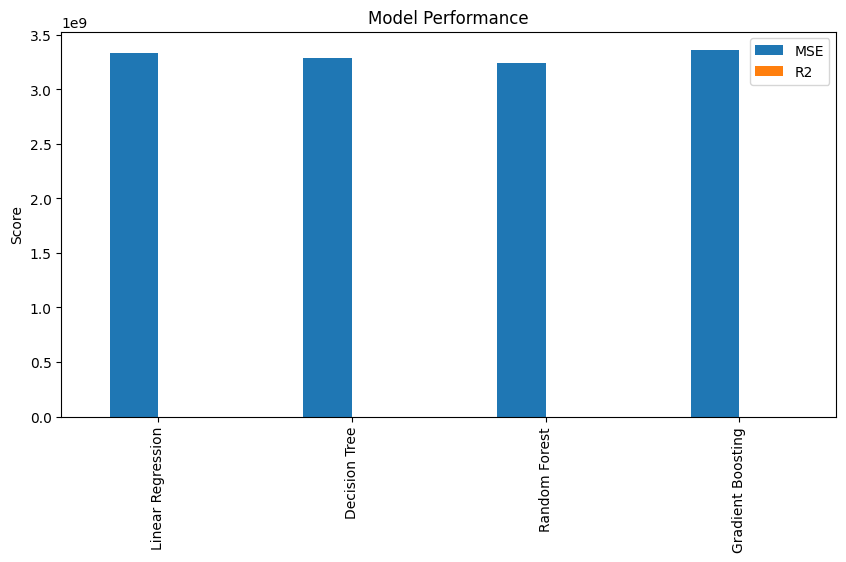

In [20]:
# Visualize the results
results_df = pd.DataFrame(results).T
results_df.plot(kind='bar', figsize=(10, 5))
plt.title('Model Performance')
plt.ylabel('Score')
plt.show()